In [12]:
import cirq
import qsimcirq
import numpy as np
import qiskit
import qiskit_ibm_runtime

from qiskit.visualization import plot_histogram
from encoded.dj import dj

## Computer parameters

In [ ]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()
#computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation values (physical and encoded) are 1.0.

# Option 2: Use noise characteristics from most recent calibration.
# service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
# computer = service.backend("ibm_kyiv")
# computer = AerSimulator.from_backend(computer)

# See calibration data at https://quantum.ibm.com/services/resources to select good qubits.
layout = {
    1 : [0,1],
    7 : [61, 62, 63, 64, 65, 66, 67, 72, 73, 81, 82, 83, 84, 85],
}

## Oracle definition

In [8]:
total_qubits = 4
# Random case
# oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
# if oracleType == 1:
#     oracleValue = np.random.randint(1, 2**(total_qubits-1))


# Fixed case
# Here we give the more complex case
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
oracleType,oracleValue

(1, 7)

## Analog version

In [19]:

noise_p = 0.01
n_shots = 10000

qreg = cirq.LineQubit.range(total_qubits)
circuit, type_, value_ = dj(qreg,oracleType,oracleValue)
# circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))

# c_m = circuit.copy()
# if noise_p > 0.0:
#     c_m = c_m.with_noise(cirq.depolarize(p=noise_p))
# s = qsimcirq.QSimSimulator()
# samples = s.run(c_m, repetitions=n_shots)
# counts = samples.histogram(key="m")
# results = {}
# for key in counts.keys():
#     results[key] = counts[key]

# print(circuit)
# print("type is " + str(type_) + " value is " + str(value_))
# print(results)

In [ ]:
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
circuit.measure_active()
# Compile to device.
compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  # Hardcode n = 1 (i.e., no encoding) to get layout.
    routing_method="sabre",
    # scheduling_method="asap",
    optimization_level=0,
)

job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

NameError: name 'compute_expectation' is not defined

In [21]:
counts

{'1001': 10,
 '1010': 4,
 '0010': 8,
 '0000': 14,
 '1011': 76,
 '1111': 3613,
 '1101': 474,
 '0110': 421,
 '1100': 413,
 '0100': 396,
 '0101': 471,
 '0001': 6,
 '0011': 66,
 '0111': 3592,
 '1000': 13,
 '1110': 423}

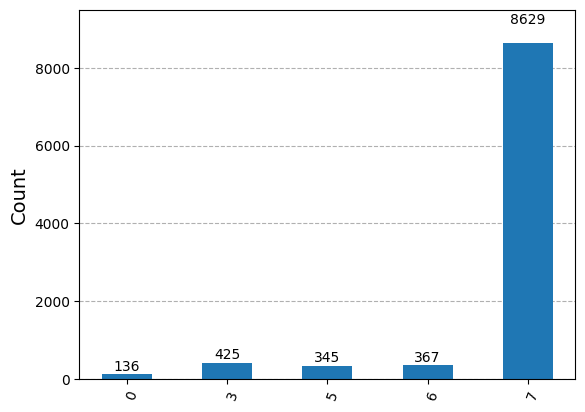

In [10]:
threshold = int(0.01 * n_shots) # the threshold of plotting significant measurements, 1% of the default number of shots, 1024
filteredAnswer = {k: v for k,v in results.items() if v >= threshold} # filter the answer for better view of plots
removedCounts = np.sum([ v for k,v in results.items() if v < threshold ]) # number of counts removed 
plot_histogram(filteredAnswer)